# Music genre classification notebook

## Importing Libraries

In [102]:
# feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

## Extracting music and features

### Dataset

We use [GTZAN genre collection](http://marsyasweb.appspot.com/download/data_sets/) dataset for classification. 
<br>
<br>
The dataset consists of 10 genres i.e
 * Blues
 * Classical
 * Country
 * Disco
 * Hiphop
 * Jazz
 * Metal
 * Pop
 * Reggae
 * Rock
 
Each genre contains 100 songs. Total dataset: 1000 songs

## Extracting the Spectrogram for every Audio

SystemError: <built-in method write of _io.BufferedWriter object at 0x7efd9801ee08> returned a result with an error set

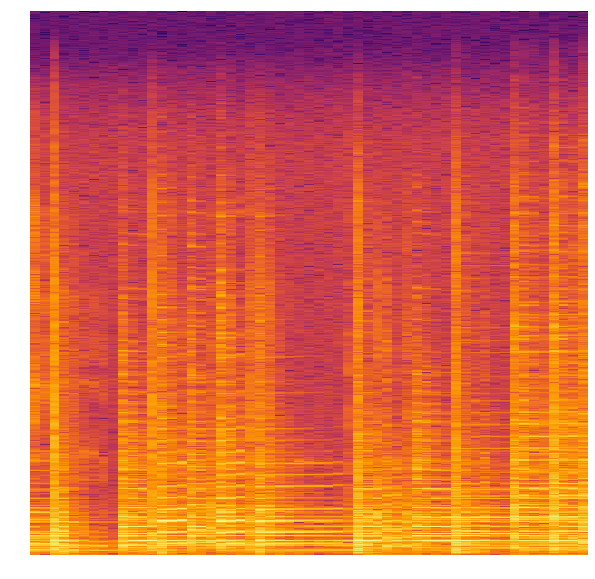

In [103]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'../../audio/testfiles/GTZAN/genres/{g}'):
        songname = f'../../audio/testfiles/GTZAN/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 

All the audio files get converted into their respective spectrograms .WE can noe easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [ ]:
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file 

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
filepath = '../../audio/testfiles/GTZAN/genres/'
for g in genres:
    for filename in os.listdir(f'{filepath}/{g}'):
        songname = f'{filepath}/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        #rmse = librosa.feature.rmse(y=y, S=None, frame_length=2048, hop_length=512, center=True, pad_mode='reflect')
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        #to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# Analysing the Data in Pandas

In [ ]:
data = pd.read_csv('data.csv')
data.head()

In [ ]:
data.shape

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

## Dividing data into training and Testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
len(y_train)

In [ ]:
len(y_test)

In [ ]:
X_train[10]

# Classification with Keras

## Building our Network

In [104]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='softmax'))

In [105]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [106]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=128)
                   

Epoch 1/200
800/800 [==============================] - 1s 976us/step - loss: 2.2211 - acc: 0.2038
Epoch 2/200
800/800 [==============================] - 0s 42us/step - loss: 1.9329 - acc: 0.3788
Epoch 3/200
800/800 [==============================] - 0s 48us/step - loss: 1.7124 - acc: 0.4250
Epoch 4/200
800/800 [==============================] - 0s 49us/step - loss: 1.5134 - acc: 0.4612
Epoch 5/200
800/800 [==============================] - 0s 39us/step - loss: 1.3565 - acc: 0.5288
Epoch 6/200
800/800 [==============================] - 0s 39us/step - loss: 1.2445 - acc: 0.5650
Epoch 7/200
800/800 [==============================] - 0s 51us/step - loss: 1.1424 - acc: 0.6050
Epoch 8/200
800/800 [==============================] - 0s 36us/step - loss: 1.0616 - acc: 0.6350
Epoch 9/200
800/800 [==============================] - 0s 48us/step - loss: 1.0050 - acc: 0.6687
Epoch 10/200
800/800 [==============================] - 0s 55us/step - loss: 0.9461 - acc: 0.6788
Epoch 11/200
800/800 [======

800/800 [==============================] - 0s 39us/step - loss: 0.0053 - acc: 0.9988
Epoch 167/200
800/800 [==============================] - 0s 59us/step - loss: 0.0060 - acc: 0.9988
Epoch 168/200
800/800 [==============================] - 0s 41us/step - loss: 0.0054 - acc: 0.9988
Epoch 169/200
800/800 [==============================] - 0s 54us/step - loss: 0.0052 - acc: 0.9988
Epoch 170/200
800/800 [==============================] - 0s 46us/step - loss: 0.0052 - acc: 0.9988
Epoch 171/200
800/800 [==============================] - 0s 47us/step - loss: 0.0059 - acc: 0.9988
Epoch 172/200
800/800 [==============================] - 0s 52us/step - loss: 0.0071 - acc: 0.9975
Epoch 173/200
800/800 [==============================] - 0s 47us/step - loss: 0.0072 - acc: 0.9975
Epoch 174/200
800/800 [==============================] - 0s 45us/step - loss: 0.0054 - acc: 0.9988
Epoch 175/200
800/800 [==============================] - 0s 49us/step - loss: 0.0054 - acc: 0.9975
Epoch 176/200
800/800 [=

In [107]:
test_loss, test_acc = model.evaluate(X_test,y_test)

200/200 [==============================] - 0s 1ms/step


In [108]:
print('test_acc: ',test_acc)

test_acc:  0.69


Tes accuracy is less than training dataa accuracy. This hints at Overfitting

## Validating our approach
Let's set apart 200 samples in our training data to use as a validation set:

In [109]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

Now let's train our network for 20 epochs:

In [110]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=200,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/200
600/600 [==============================] - 1s 2ms/step - loss: 2.2915 - acc: 0.1050 - val_loss: 2.1707 - val_acc: 0.3900
Epoch 2/200
600/600 [==============================] - 0s 78us/step - loss: 2.1480 - acc: 0.4150 - val_loss: 2.0414 - val_acc: 0.4100
Epoch 3/200
600/600 [==============================] - 0s 62us/step - loss: 2.0109 - acc: 0.4233 - val_loss: 1.9110 - val_acc: 0.3950
Epoch 4/200
600/600 [==============================] - 0s 105us/step - loss: 1.8651 - acc: 0.4267 - val_loss: 1.7823 - val_acc: 0.4000
Epoch 5/200
600/600 [==============================] - 0s 75us/step - loss: 1.7271 - acc: 0.4300 - val_loss: 1.6616 - val_acc: 0.4250
Epoch 6/200
600/600 [==============================] - 0s 92us/step - loss: 1.5869 - acc: 0.4533 - val_loss: 1.5710 - val_acc: 0.4350
Epoch 7/200
600/600 [==============================] - 0s 93us/step - loss: 1.4683 - acc: 0.5133 - val_loss: 1.5001 - val_acc: 0.4750
Epoch 8/200
600/

600/600 [==============================] - 0s 70us/step - loss: 0.0223 - acc: 0.9983 - val_loss: 1.7777 - val_acc: 0.6450
Epoch 122/200
600/600 [==============================] - 0s 56us/step - loss: 0.0186 - acc: 0.9983 - val_loss: 1.7862 - val_acc: 0.6400
Epoch 123/200
600/600 [==============================] - 0s 54us/step - loss: 0.0184 - acc: 0.9983 - val_loss: 1.8006 - val_acc: 0.6450
Epoch 124/200
600/600 [==============================] - 0s 54us/step - loss: 0.0197 - acc: 0.9983 - val_loss: 1.8044 - val_acc: 0.6450
Epoch 125/200
600/600 [==============================] - 0s 55us/step - loss: 0.0177 - acc: 0.9983 - val_loss: 1.8062 - val_acc: 0.6450
Epoch 126/200
600/600 [==============================] - 0s 54us/step - loss: 0.0155 - acc: 0.9983 - val_loss: 1.8138 - val_acc: 0.6500
Epoch 127/200
600/600 [==============================] - 0s 49us/step - loss: 0.0154 - acc: 0.9983 - val_loss: 1.8242 - val_acc: 0.6500
Epoch 128/200
600/600 [==============================] - 0s 66

In [111]:
results

[1.9170585727691651, 0.655]

## Predictions on Test Data

In [112]:
predictions = model.predict(X_test)

In [113]:
predictions[0].shape

(10,)

In [114]:
np.sum(predictions[0])

1.0

In [115]:
np.argmax(predictions[0])

2